<a href="https://colab.research.google.com/github/hatimnaitlho/ml-sklearn/blob/master/breast_cancer_prediction_using_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Prediction using Supervised Machine Learning Algorithms

In this notebook we will build, assess and compare some classifier algorithms based on Wisconsin Breast Cancer diagnosis  dataset. This dataset is computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

The classifier algorithm we will focus on are:
- SVM
- Ensemble methods
- Logistic Regression
- Decision tree


In [0]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import seaborn as sns


# to make this notebook's output reproducible across runs
np.random.seed(42)

### Loading the cancer dataset

In [0]:
from sklearn import datasets

cancer_dataset = datasets.load_breast_cancer()

# Exploring the cancer dataset

In [14]:
cancer_dataset.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [15]:
print(cancer_dataset.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

# Exploratory Data Analysis & Features Selection

Let's build the cancer breast dataframe based on `'data'` and `'feature_names'`, which is more convenient.

In [48]:
df = pd.DataFrame(data=cancer_dataset.data, columns=list(cancer_dataset.feature_names))
df['target']= cancer_dataset.target
df.tail(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
559,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,0.06570,0.2388,2.904,1.936,16.97,0.008200,0.029820,0.05738,0.01267,0.01488,0.004738,12.480,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732,1
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.492,2.888,29.84,0.007256,0.026780,0.02071,0.01626,0.02080,0.005304,15.300,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321,1
561,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,0.05502,0.3141,3.896,2.041,22.81,0.007594,0.008878,0.00000,0.00000,0.01989,0.001773,11.920,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905,1
562,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,0.07152,0.2602,1.205,2.362,22.65,0.004625,0.048440,0.07359,0.01608,0.02137,0.006142,17.520,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090,0
563,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,0.9622,1.026,8.758,118.80,0.006399,0.043100,0.07845,0.02624,0.02057,0.006213,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.25420,0.2929,0.09873,0
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.028910,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.22160,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.024230,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.16280,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.037310,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.14180,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.595,5.772,86.22,0.006522,0.061580,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.26500,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.004660,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039,1


In [49]:
print('Data Set Characteristics:')
print('The Number of Instances is: {}'.format(df.shape[0]))
print('The Number of Attributes is: {}'.format(df.shape[1]-1))

Data Set Characteristics:
The Number of Instances is: 569
The Number of Attributes is: 30


In [0]:
# Fill empty and NaNs values with NaN
df = df.fillna(np.nan)

# Check for Null values
df.isnull().sum()

### Feature selection
Let's first plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable `target`.

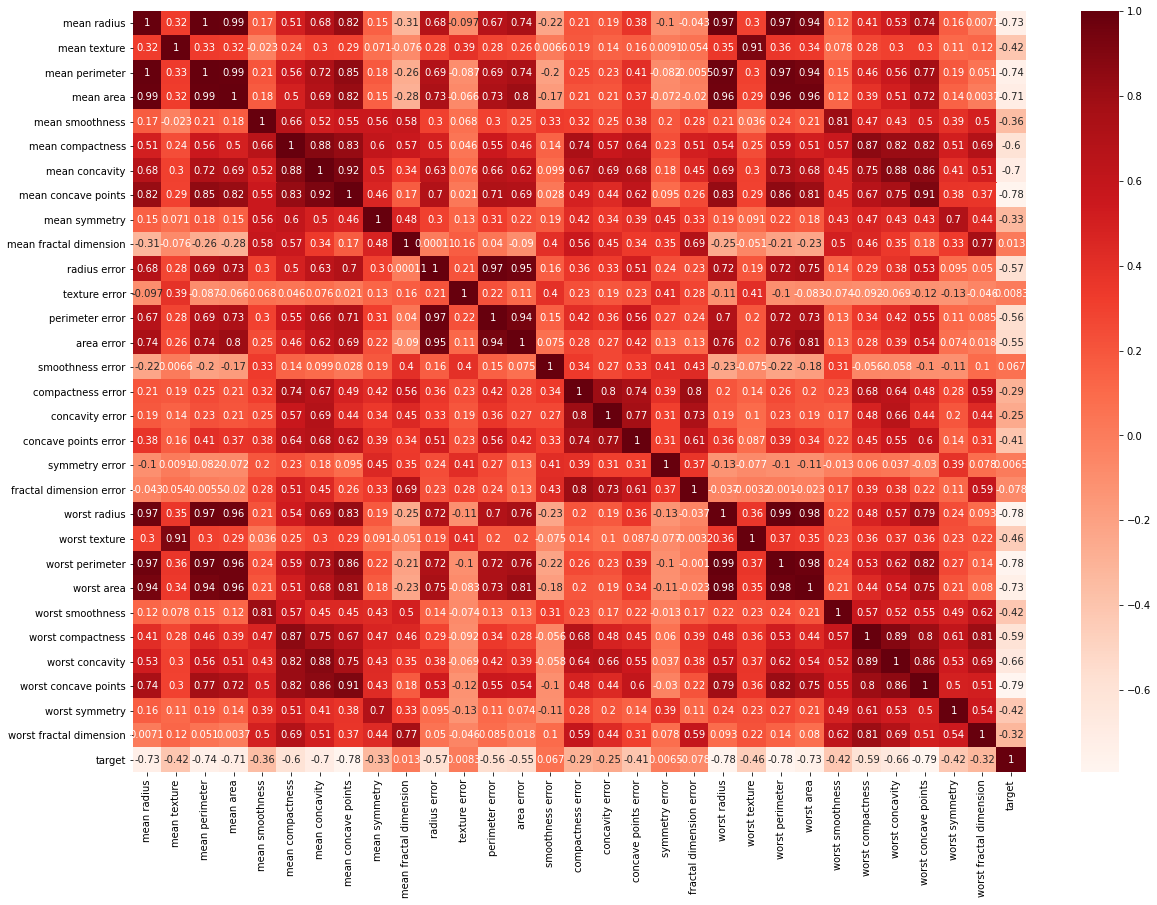

In [78]:
# Correlation matrix
cor = df.corr()

plt.figure(figsize = (20,14))

g = sns.heatmap(df.corr(), annot=True, cmap = plt.cm.Reds)

In [80]:
#Correlation with the output variable
cor_target = abs(cor['target'])
#Selecting moderate to highly correlated features
relevant_features = cor_target[cor_target>=0.3]
print('The number of highly relevant features is: {}'.format(relevant_features.shape[0]))
relevant_features

The number of highly relevant features is: 24


mean radius                0.730029
mean texture               0.415185
mean perimeter             0.742636
mean area                  0.708984
mean smoothness            0.358560
mean compactness           0.596534
mean concavity             0.696360
mean concave points        0.776614
mean symmetry              0.330499
radius error               0.567134
perimeter error            0.556141
area error                 0.548236
concave points error       0.408042
worst radius               0.776454
worst texture              0.456903
worst perimeter            0.782914
worst area                 0.733825
worst smoothness           0.421465
worst compactness          0.590998
worst concavity            0.659610
worst concave points       0.793566
worst symmetry             0.416294
worst fractal dimension    0.323872
target                     1.000000
Name: target, dtype: float64

In [84]:
features_to_drop = cor_target[cor_target<=0.3]
features_to_drop

mean fractal dimension     0.012838
texture error              0.008303
smoothness error           0.067016
compactness error          0.292999
concavity error            0.253730
symmetry error             0.006522
fractal dimension error    0.077972
Name: target, dtype: float64

Now let's drop the features considered as having low correlation with the target. `mean fractal dimension`, `texture error`, `smoothness error`, `compactness error`, `concavity error`, `symmetry error`, `fractal dimension error`

In [0]:
dfc= df.copy()
dfc.drop(columns=['mean fractal dimension', 'texture error', 'smoothness error', 'compactness error', 
                  'concavity error', 'symmetry error', 'fractal dimension error'], inplace= True)

In [0]:
X= dfc.drop(columns=['target'])
y= dfc['target']

# Building the model

In [0]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [93]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Evaluating the Model
Let's estimate how accurately the classifier or model can predict the breast cancer of patients.

Accuracy can be computed by comparing actual test set values and predicted values.

In [95]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9649122807017544


Well, you got a classification rate of 96.49%, considered as very good accuracy. However, precision is not considered as the good metric in this case. We need a metric that assess the probability that each positive cases (cancer breast positive) are detected, and we need that the false negative (meaning a patient that have the breast cancer is not diagnostiged) are near zero. Therefore, we will use Precision and recall:

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

Recall is The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

***Recall is more important than precision in a breast cancer predictor.***

In [96]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", metrics.recall_score(y_test, y_pred))

Precision: 0.958904109589041
Recall: 0.9859154929577465


Well, we got a precision of 95.89% and recall of 98.59%, which are considered as very good values. We can now say that we have a good confidence of our model